In [12]:
import numpy as np
import cv2 as cv
from skimage.morphology import skeletonize
import glob
import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from PIL import Image
import sknw
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.stats import linregress
import pymannkendall as mk

In [2]:
data = pd.read_excel("data.xlsx")

In [3]:
df = pd.DataFrame(columns=["year", "mean_connections"])
for a in tqdm.tqdm(glob.glob("skeletons/*.png")):
    ark = a[10:-7]
    im = cv.imread(a, cv.IMREAD_GRAYSCALE).astype(np.uint16)
    year = data[data.ark == "12148_"+ark].date.values[0]
    if year != year:
        continue
    graph = sknw.build_sknw(im)
    
    deg = graph.degree
    to_delete = []
    for node in graph.nodes(data=True):
        if deg[node[0]] == 1:
            for neighbor in graph.neighbors(node[0]):
                if np.linalg.norm(node[1]['o']-graph.nodes[neighbor]['o']) < 30:
                    to_delete.append(node[0])

    for node in to_delete:
        graph.remove_node(node)
    deg = graph.degree
    m = 0
    count = 0
    for d in deg:
        if np.linalg.norm(graph.nodes[d[0]]['o'] - [5078,4248]) <= 1190:
            m+=d[1]
            count += 1
        
    df = df.append({"year":year, "mean_connections":m/count}, ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████| 346/346 [06:49<00:00,  1.18s/it]


In [4]:
groups = np.percentile(df.year, range(10,101,10))

In [5]:
groups

array([1830. , 1840. , 1842. , 1846. , 1852. , 1862. , 1876.7, 1889. ,
       1907. , 1949. ])

In [6]:
def divide_in_groups(year):
    i = 0
    while year > groups[i]:
        i+=1
    return i

In [7]:
df["group"] = df.year.apply(divide_in_groups)

In [8]:
only_take = df[(df.group !=0)&(df.group!=9)]

In [9]:
ticks = []
for i in range(1,len(groups)-1):
    ticks.append(f"{int(groups[i-1])} - {int(groups[i])}")

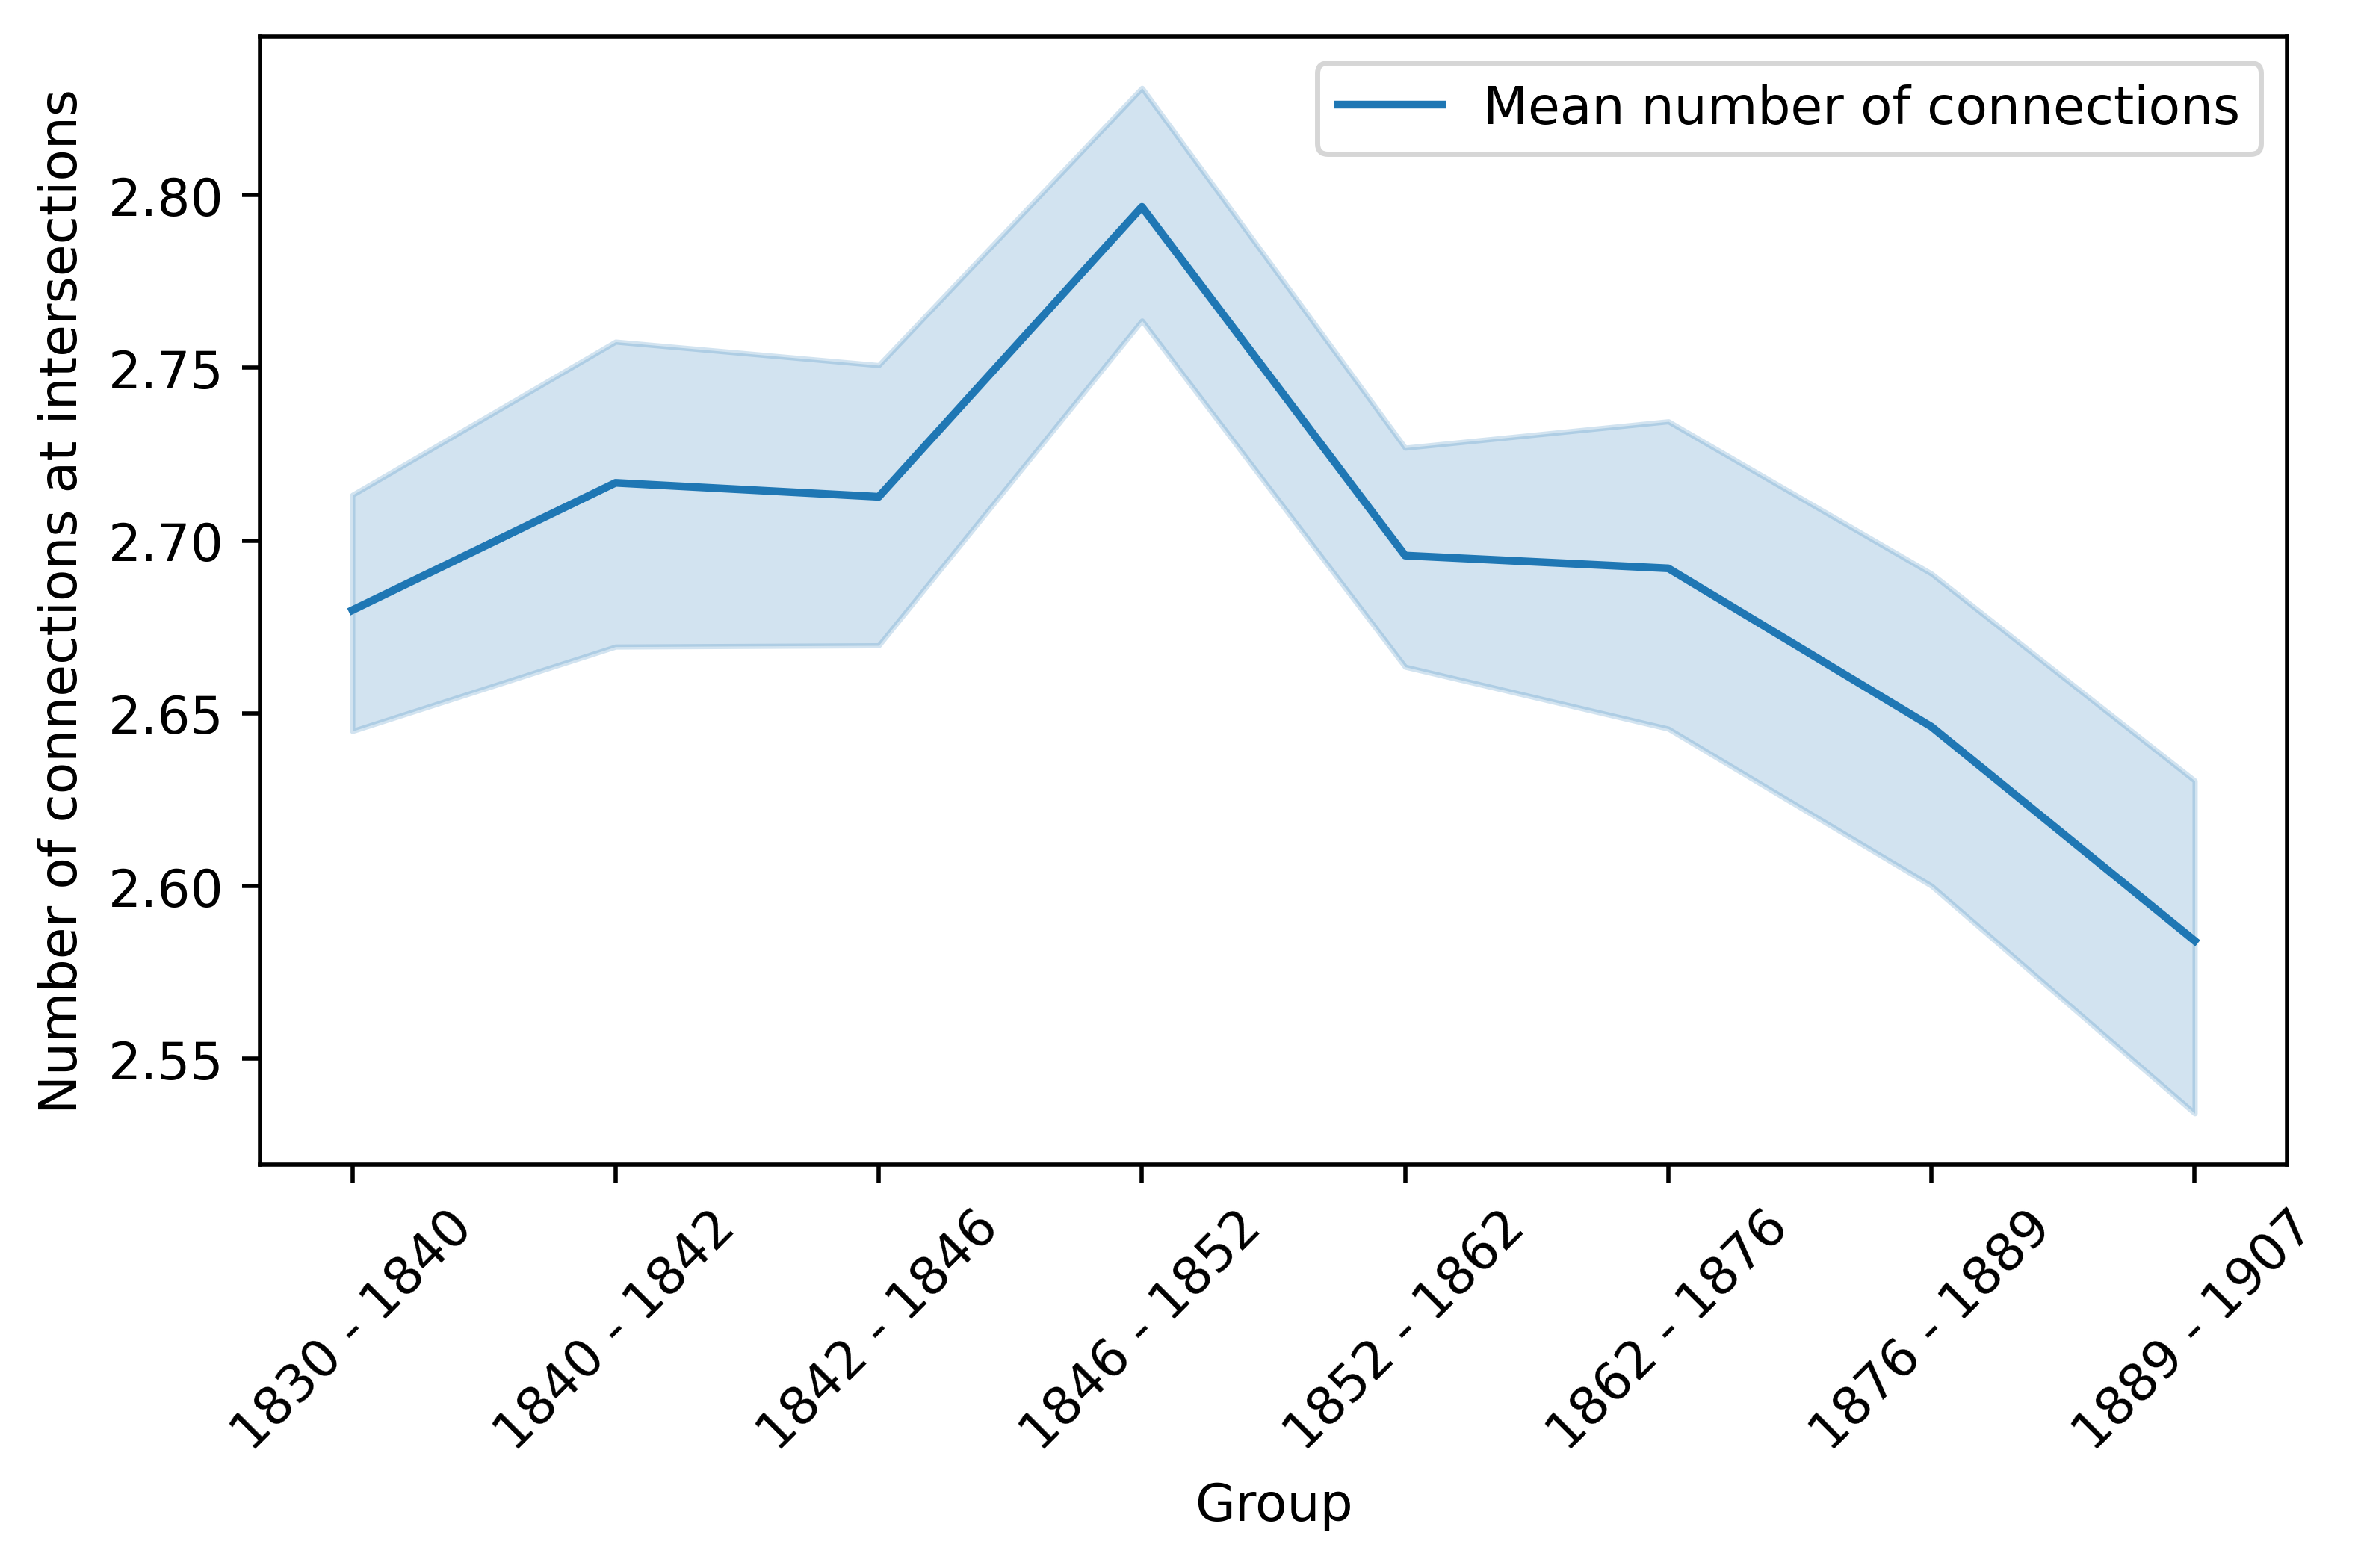

In [10]:
sns.reset_orig()
f, ax = plt.subplots(figsize=(7, 4), dpi=500)
palette = sns.color_palette("tab10", 8)
ax = sns.lineplot(data=only_take, x="group", y="mean_connections", label="Mean number of connections")

ax.set_xlabel("Group")
ax.set_ylabel("Number of connections at intersections")
ax.set_xticks(range(1,9))
ax.set_xticklabels(ticks)
plt.xticks(rotation=45)
plt.show()

In [13]:
only_take.groupby(by="group").mean().mean_connections.values

array([2.67986447, 2.71673233, 2.71268694, 2.79658737, 2.69567335,
       2.69197421, 2.64611711, 2.58416999])

In [14]:
mk.original_test(only_take.groupby(by="group").mean().mean_connections.values, alpha=0.10)

Mann_Kendall_Test(trend='no trend', h=False, p=0.10776229039192153, z=-1.6083328927425289, Tau=-0.5, s=-14.0, var_s=65.33333333333333, slope=-0.011088716865194446, intercept=2.732634286850782)